In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the Keras libraries and other packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, Activation
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
import pandas as pd
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.models import load_model
from tensorflow.keras import applications
from tensorflow.keras import optimizers

In [3]:
img_width, img_height = 224, 224
train_data_dir = r'D:\Code\Project-ML\Image_Classification\Dataset\train'
validation_data_dir = r'D:\Code\Project-ML\Image_Classification\Dataset\test'

In [4]:
model = applications.VGG16(weights = 'imagenet',
                           include_top=False,
                           input_shape = (img_width, img_height, 3))

In [5]:
for layer in model.layers[:6]:
    layer.trainable = True

In [6]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

In [7]:
model_final = Model(inputs = model.input, outputs= predictions)

In [8]:
model_final.compile(loss = 'categorical_crossentropy',
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                    metrics=['accuracy'])

In [9]:
# Part 2 - Read and pre-preocess images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    batch_size = 32, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    class_mode = "categorical")

Found 8048 images belonging to 2 classes.
Found 1637 images belonging to 2 classes.


In [11]:
checkpoint = ModelCheckpoint(r"D:\Code\Project-ML\Image_Classification\Save_Model_h5\transfer_fish_plasticwaste_VGG16.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq=1)
early = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')

In [12]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
import datetime
t0 = datetime.datetime.now()
print(t0)

2023-04-25 20:28:31.601327


In [14]:
history = model_final.fit(train_generator, 
                          epochs=100,
                          validation_data = validation_generator,
                          verbose = 1,
                          callbacks = [checkpoint, early])

Epoch 1/100


In [ ]:
t1 = datetime.datetime.now()
print(t1-t0)

0:17:36.014507


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.tail()

<AxesSubplot:>

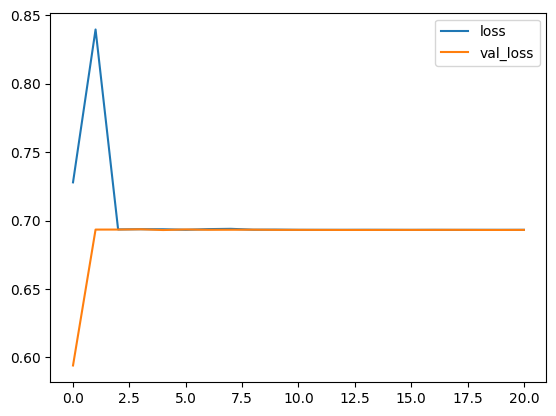

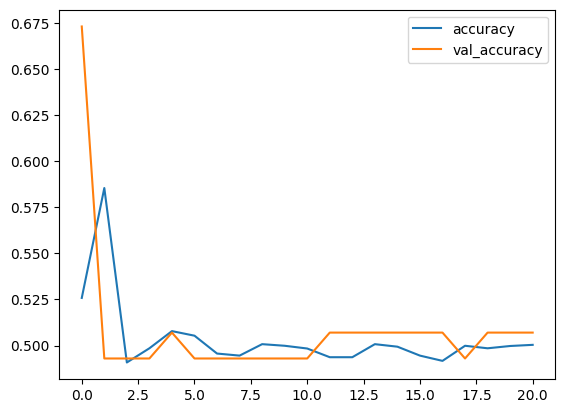

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

#### Nhận xét:
- Model đạt valid_accuracy tương đối ~ 93.34%
- => Thử thêm model khác: inception_resnet_v2, .v.v.

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
#save model
model_final.save(r'D:\Code\Project-ML\Image_Classification\Save_Model_h5\transfer_fish_plasticwaste_VGG16_model.h5')
print('save!!!')

Saved


In [ ]:
model = load_model(r'D:\Code\Project-ML\Image_Classification\Save_Model_h5\transfer_fish_plasticwaste_VGG16_model.h5')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
def result(test_image):
    test_image = image.img_to_array(test_image)
    test_image = test_image/255
    test_image = np.expand_dims(test_image, axis= 0)
    result = model.predict(test_image)

    # 0 la fish, 1 la plastic, nguong sigmoid = 0.5
    if result[0][0] >= 0.5:
        prediction = 'Fish'
    else:
        prediction = 'PlasticWaste'
    return prediction

In [ ]:
train_evaluation= model.evaluate(train_generator)
test_evaluation= model.evaluate(validation_generator)
print('Train Accuracy:', round(train_evaluation[1], 4), 
        '; Train loss:', round(train_evaluation[0], 4))
print('Test Accuracy:', round(test_evaluation[1], 4), 
        '; Test loss:', round(test_evaluation[0], 4))

In [ ]:
import os 
predict_path= r'D:\Code\Project-ML\Image_Classification\Dataset\single_prediction\\'
list_image= os.listdir(predict_path)

In [ ]:
df= pd.DataFrame(columns=['name_file', 'truth', 'predict'])
name_file=[]
truth=[]
predict=[]

In [ ]:
for i in range(len(list_image)):
    path= predict_path + list_image[i]
    test_img= image.load_img(path, target_size=[img_width, img_height])
    name_file.append(list_image[i])
    truth.append(list_image[i].split('_')[0])
    predict.append(result(test_img))

df['name_file']= name_file
df['truth']= truth
df['predict']= predict
df.to_csv(r'D:\Code\Project-ML\Computer_Vision\Pre-trained_Model\Resnet50_v2\prediction_fish_and_plasticwaste_VGG16.csv')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
confusion_matrix(df['truth'], df['predict'])

In [ ]:
print(classification_report(df['truth'], df['predict']))